### Imports

In [1]:
import tensorflow as tf
from tensorflow.keras import layers  # Ensure layers are properly imported
import matplotlib.pyplot as plt
import numpy as np
from itertools import groupby
import json
import os
import cv2
import supervision as sv
from sklearn.model_selection import train_test_split

BATCH_SIZE = 26000
RESNET_SHAPE = (224, 224, 3)
MASK_PATH = "../Data/Image_Masks"
IMAGE_PATH = "../Data/Weather_Dataset"

### Data Load

In [2]:
sam_dataset_images = np.load("../Data/SAM_Dataset/sam_dataset_images.npy")
sam_dataset_labels = np.load("../Data/SAM_Dataset/sam_dataset_labels.npy")
sam_dataset_weights = np.load("../Data/SAM_Dataset/sam_dataset_weights.npy")
sam_dataset_orig_images = np.load("../Data/SAM_Dataset/sam_dataset_orig_images.npy")

In [3]:
sam_1 = np.load("../Data/SAM_Dataset/sam_features_1.npy")
sam_2 = np.load("../Data/SAM_Dataset/sam_features_2.npy")
sam_3 = np.load("../Data/SAM_Dataset/sam_features_3.npy")
sam_4 = np.load("../Data/SAM_Dataset/sam_features_4.npy")
sam_5 = np.load("../Data/SAM_Dataset/sam_features_5.npy")
sam_6 = np.load("../Data/SAM_Dataset/sam_features_6.npy")
sam_7 = np.load("../Data/SAM_Dataset/sam_features_7.npy")

all_sam_features = [
    sam_1,
    sam_2,
    sam_3,
    sam_4,
    sam_5,
    sam_6,
    sam_7
]
sam_ds = np.vstack(all_sam_features)
sam_ds.shape

(184019, 2048)

### Processing Functions

In [16]:
with open(os.path.join(MASK_PATH, "glaze/6090.json"), 'r') as f:
    a = json.load(f)

a['masks'][0].keys()

dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])

In [171]:
def get_overlap_ratio(running_mask, new_mask):
    """
    Calculate the overlap of a new mask with a running mask.
    """
    # Ensure both masks are binary
    running_mask = (running_mask > 0).astype(np.uint8)
    new_mask = (new_mask > 0).astype(np.uint8)

    # Calculate intersection
    intersection = np.logical_and(running_mask, new_mask).astype(np.uint8)

    new_mask_sum = np.sum(new_mask)

    # Calculate overlap ratio
    if new_mask_sum == 0:
        return 0.0  # Avoid division by zero

    overlap_ratio = np.sum(intersection) / new_mask_sum

    return overlap_ratio

def get_top_n_non_overlapping_masks(mask_data, top_n=5, remove_top_n=0, max_overlap=0.2):

    # mask_data is sorted

    mask_indices = []

    grand_mask = np.zeros(RESNET_SHAPE[:2], dtype=np.uint8)  # Initialize a grand mask to accumulate the masks
    i = 0
    while len(mask_indices) < top_n and i < len(mask_data):
        mask = np.array(mask_data[i]['segmentation']).astype(np.uint8)  # Convert the segmentation to a numpy array

        if not grand_mask.any():
            grand_mask = mask.astype(np.uint8)
            continue
        
        overlap_ratio = get_overlap_ratio(grand_mask, mask)
        if overlap_ratio < 0.25:
            continue

        if remove_top_n > 0:
            remove_top_n -= 1  
            continue

        grand_mask = grand_mask + mask # Accumulate the mask into the grand mask
        grand_mask = (grand_mask > 0).astype(np.uint8)

        mask_indices.append(mask)
        i += 1

    return mask_indices

def get_top_n_masks(image_id, top_n=5, sam_image_json=None, remove_top_n=0):
    
    # Go to Data/Image_Masks/{image_id}.json
    if sam_image_json is None:
        with open(os.path.join(MASK_PATH, f"{image_id}.json"), "r") as f:
            sam_image_json = json.load(f)  # Load the JSON file for the image

    # Unpack first n masks from the masks

    mask_data = sorted(sam_image_json['masks'], key=lambda x: -x['area'])

    


    mask_data = mask_data[remove_top_n:top_n+remove_top_n]
    mask_data = [
        [
            mask['segmentation'],
            mask['area'],
            mask['bbox']
        ]
        for mask in mask_data
    ]

    # Return mask data with their areas and bounding boxes

    masks, areas, bounding_boxes = zip(*mask_data)

    return np.array(masks), np.array(areas), np.array(bounding_boxes)
    

def get_top_p_masks(image_id, p=0.2, remove_top_n=0):
    with open(os.path.join(MASK_PATH, f"{image_id}.json"), "r") as f:
        sam_image_json = json.load(f)  # Load the JSON file for the image
    
    n = len(sam_image_json['masks'])

    return get_top_n_masks(
        image_id,
        top_n=int(n * p),  # Calculate the number of masks to return based on percentage p
        sam_image_json=sam_image_json,
        remove_top_n=remove_top_n  # Allow for removing top n masks before calculating top p
    )

def get_bounding_box(mask: np.ndarray):
    assert mask.ndim == 2, "Input must be a 2D boolean array"
    
    rows = np.any(mask, axis=1)
    cols = np.any(mask, axis=0)

    if not rows.any() or not cols.any():
        return None  # No True values found
    
    row_min, row_max = np.where(rows)[0][[0, -1]]
    col_min, col_max = np.where(cols)[0][[0, -1]]

    # Return as (top, left, bottom, right)
    bbox = [col_min, row_min, col_max - col_min, row_max - row_min]
    
    return list(map(int, bbox))

def read_image(image_id):
    image_bgr = cv2.imread(os.path.join(IMAGE_PATH, f"{image_id}.jpg"))  # Read the image in BGR format
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    image_rgb = cv2.resize(image_rgb, RESNET_SHAPE[:2])
    
    return image_rgb  # Resize to the target shape (224, 224)


def crop_and_resize(image, bbox, shape=RESNET_SHAPE):
    x_min, y_min, width, height = bbox
    cropped_image = image[y_min:y_min + height, x_min:x_min + width]
    cropped_image = cropped_image.astype(np.uint8)  # Ensure the cropped image is in uint8 format for cv2 resizing
    resized_image = cv2.resize(cropped_image, shape[:2], interpolation=cv2.INTER_LINEAR)  # Resize to the target shape (224, 224)
    return resized_image

def reconstruct_image_from_masks(image_id, top_n=None, p=None, target_size=RESNET_SHAPE, remove_top_n=0):

    # Get masks
    if top_n is not None:
        masks, areas, bounding_boxes = get_top_n_masks(image_id, top_n=top_n, remove_top_n=remove_top_n)
    elif p is not None:
        masks, areas, bounding_boxes = get_top_p_masks(image_id, p=p, remove_top_n=remove_top_n)

    # Add together
    composite_mask = (sum(masks) > 0).astype(np.uint8)  # Create a composite mask by summing the individual masks and thresholding to binary (0 or 1)

    # Load the original image
    
    orig_image = read_image(image_id)  # Load the original image in RGB format

    image = orig_image * np.stack([composite_mask]*3, axis=-1)

    # Get composite bounding boxes

    composite_bounding_box = get_bounding_box(composite_mask)

    # Resize from composite bounding boxes to the target size (224, 224)

    image = crop_and_resize(image, composite_bounding_box, shape=target_size)

    return image


In [178]:
masks, areas, bboxes = get_top_n_masks("glaze/6090", top_n=6, remove_top_n=1)

In [180]:
img = read_image("glaze/6090")  # Read the original image in RGB format

composite_mask = sum(masks)

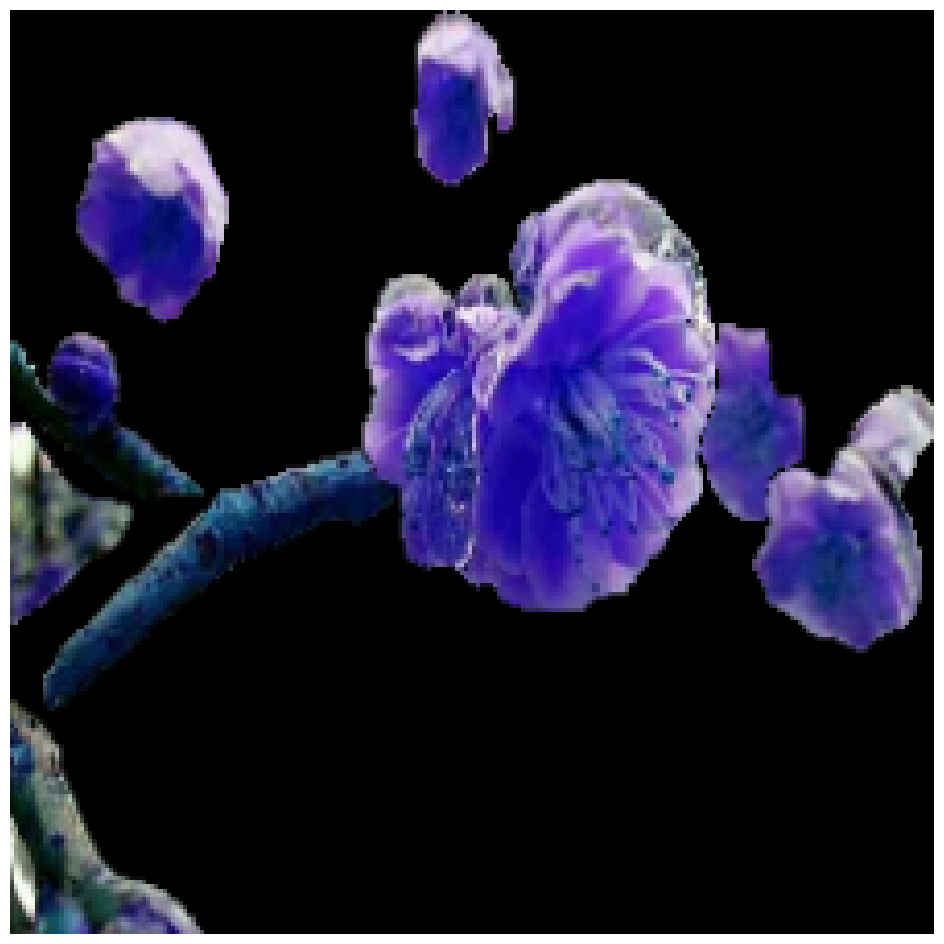

In [183]:
sample_image = "glaze/6090"  # Example image ID to test the function
reconstructed_image = reconstruct_image_from_masks(sample_image, top_n=12, p=None, target_size=RESNET_SHAPE, remove_top_n=1)
sv.plot_image(reconstructed_image)

In [123]:
r = reconstructed_image[:, :, 0]

In [127]:
for i in range(r.shape[0]):
    for j in range(r.shape[1]):
        if i == 0 or i == r.shape[0] - 1:
            if r[i, j] > 0:
                print(f"{r[i, j]} pixel found at ({i}, {j})")
            
        if j == r.shape[1] - 1:
            if r[i, j] > 0:
                print(f"{r[i, j]} pixel found at ({i}, {j})")

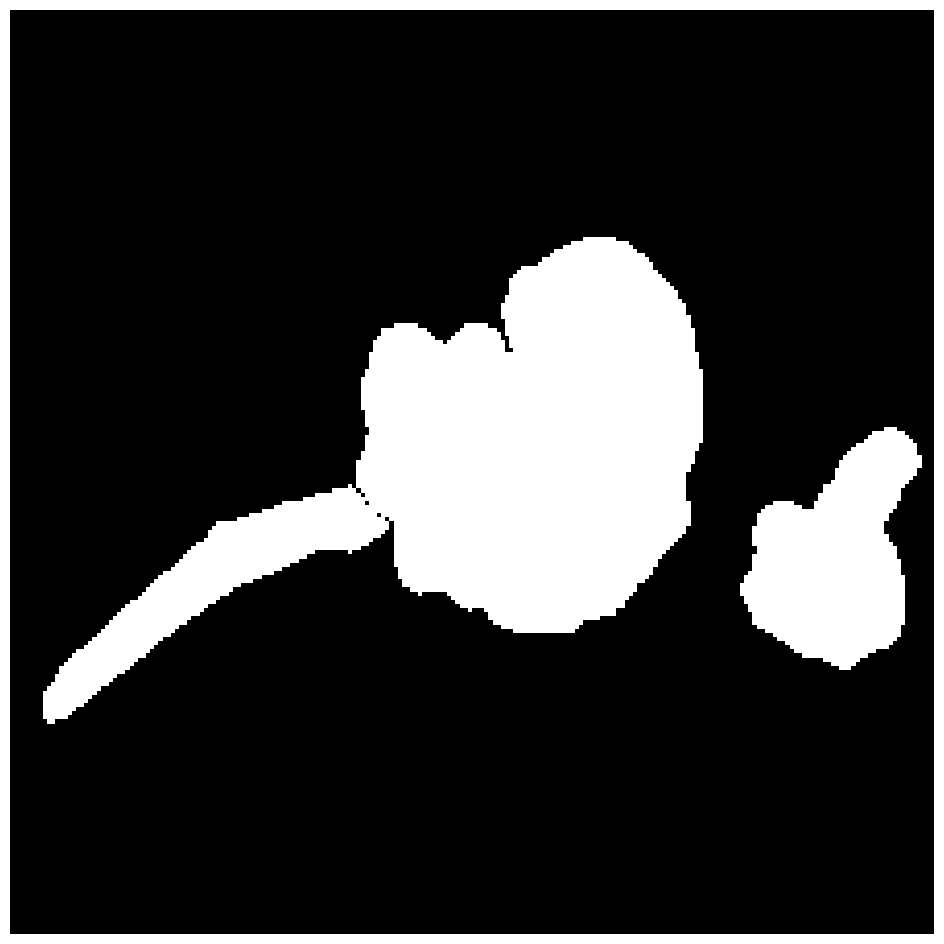

In [148]:
composite_mask = (composite_mask > 0).astype(np.uint8)  # Ensure the mask is binary (0s and 1s)
sv.plot_image(composite_mask)

In [156]:
mask = composite_mask  # Use the composite mask from the reconstruction
rows = np.any(mask, axis=1)
cols = np.any(mask, axis=0)



row_min, row_max = np.where(rows)[0][[0, -1]]
col_min, col_max = np.where(cols)[0][[0, -1]]

# Return as (top, left, bottom, right)


ret = list(map(int, bbox))

In [168]:
def next_overlap_ratio(running_mask, new_mask):
    """
    Calculate the overlap of a new mask with a running mask.
    """
    # Ensure both masks are binary
    running_mask = (running_mask > 0).astype(np.uint8)
    new_mask = (new_mask > 0).astype(np.uint8)

    # Calculate intersection
    intersection = np.logical_and(running_mask, new_mask).astype(np.uint8)

    # Calculate union
    union = np.logical_or(running_mask, new_mask).astype(np.uint8)

    # Calculate overlap ratio
    if np.sum(union) == 0:
        return 0.0  # Avoid division by zero

    overlap_ratio = np.sum(intersection) / np.sum(union)

    return overlap_ratio

In [170]:
grand_mask = np.zeros(RESNET_SHAPE[:2], dtype=np.uint8)  # Initialize a grand mask to accumulate the masks
for mask in masks:
    if not grand_mask.any():
        grand_mask = mask.astype(np.uint8)
        continue
    
    overlap_ratio = next_overlap_ratio(grand_mask, mask)
    if overlap_ratio < 0.2:
        continue

    grand_mask = grand_mask + mask.astype(np.uint8)  # Accumulate the mask into the grand mask
    grand_mask = (grand_mask > 0).astype(np.uint8)  # Ensure the grand mask remains binary


### Simple Logistic Regression on SAM Features

sam_dataset_images = np.load("../Data/SAM_Dataset/sam_dataset_images.npy")
sam_dataset_labels = np.load("../Data/SAM_Dataset/sam_dataset_labels.npy")
sam_dataset_weights = np.load("../Data/SAM_Dataset/sam_dataset_weights.npy")
sam_dataset_orig_images = np.load("../Data/SAM_Dataset/sam_dataset_orig_images.npy")

In [207]:


def get_top_n_from_tensor(dataset, labels, orig_images, top_n=5, remove_top_n=0):
    
    indices = []
    for i, (key, group) in enumerate(groupby(enumerate(orig_images), lambda x: x[1])):
        group_indices = [idx for idx, _ in group][remove_top_n:top_n+remove_top_n]
        indices.extend(group_indices)

    return indices

dataset_indices = get_top_n_from_tensor(sam_dataset_images, sam_dataset_labels, sam_dataset_orig_images, top_n=5, remove_top_n=1)       

In [208]:
X_train, X_temp, y_train, y_temp = train_test_split(
    sam_ds[dataset_indices],
    sam_dataset_labels[dataset_indices],
    test_size=0.4,
    random_state=42,
    shuffle=True,
    stratify=sam_dataset_labels[dataset_indices] 
)

In [209]:
X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.5,  
    random_state=42,
    shuffle=True,
    stratify=y_temp  
)

In [215]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [219]:
unique, counts = np.unique(y_train_res, return_counts=True)
print("Class distribution in the resampled training set:")
for cls, count in zip(unique, counts):
    print(f"Class {cls}: {count}")

Class distribution in the resampled training set:
Class 0: 3265
Class 1: 3265
Class 2: 3265
Class 3: 3265
Class 4: 3265
Class 5: 3265
Class 6: 3265
Class 7: 3265
Class 8: 3265
Class 9: 3265
Class 10: 3265


In [252]:
len(unique)

11

In [217]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter=500, solver='lbfgs', multi_class='multinomial')
log_reg.fit(X_train_res, y_train_res)

# Predict on test data
y_pred = log_reg.predict(X_test)

# Evaluate model
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.4f}")  

# Display classification report
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=classes))


Test Accuracy: 0.1049

Classification Report:
               precision    recall  f1-score   support

   lightning       0.10      1.00      0.19       674
   sandstorm       0.00      0.00      0.00       792
       glaze       0.00      0.00      0.00       454
        rain       0.00      0.00      0.00       629
        rime       0.00      0.00      0.00       555
       frost       0.00      0.00      0.00       312
     fogsmog       0.00      0.00      0.00       498
        hail       0.00      0.00      0.00       206
         dew       0.00      0.00      0.00      1089
     rainbow       0.00      0.00      0.00       640
        snow       0.00      0.00      0.00       577

    accuracy                           0.10      6426
   macro avg       0.01      0.09      0.02      6426
weighted avg       0.01      0.10      0.02      6426



In [262]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Assume X_train is your dataset with shape (19000, 2048)
# and y_train contains the corresponding labels (e.g., shape (19000,))
# For example:
# import numpy as np
# X_train = np.random.rand(19000, 2048)
# y_train = np.random.randint(0, 10, size=19000)  # Example labels for 10 classes

# Initialize T-SNE with 2 components
tsne = TSNE(n_components=2, random_state=42)

# Fit and transform the data to 2D
X_embedded = tsne.fit_transform(X_train)




In [263]:
def get_zoom_indices(points, x_min, x_max, y_min, y_max):
    """
    Get indices of points within a specified zoom rectangle.
    
    Args:
        points (np.ndarray): Array of shape (n, 2) representing the points to filter.
        x_min (float): Minimum x-coordinate of the zoom rectangle.
        x_max (float): Maximum x-coordinate of the zoom rectangle.
        y_min (float): Minimum y-coordinate of the zoom rectangle.
        y_max (float): Maximum y-coordinate of the zoom rectangle.

    Returns:
        np.ndarray: Indices of points within the specified rectangle.
    """
    indices = np.where(
        (points[:, 0] >= x_min) & (points[:, 0] <= x_max) &
        (points[:, 1] >= y_min) & (points[:, 1] <= y_max)
    )[0]
    
    return indices

In [264]:
def plot_tsne(X_embedded, y_train, zoom=None):  

    if zoom is not None:
        filtered_indices = get_zoom_indices(X_embedded, *zoom)

        X_embedded = X_embedded[filtered_indices]

        y_train = y_train[filtered_indices]

    unique_classes= np.unique(y_train)

    # Plot the results with color mapping from y_train
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y_train, cmap='viridis', s=5, alpha=0.7)
    plt.title('T-SNE Visualization of X_train (n = {}, n_classes = {})'.format(X_embedded.shape[0], len(unique_classes)))  # Display the number of points in the plot
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.colorbar(scatter, label='Label')
    plt.show()

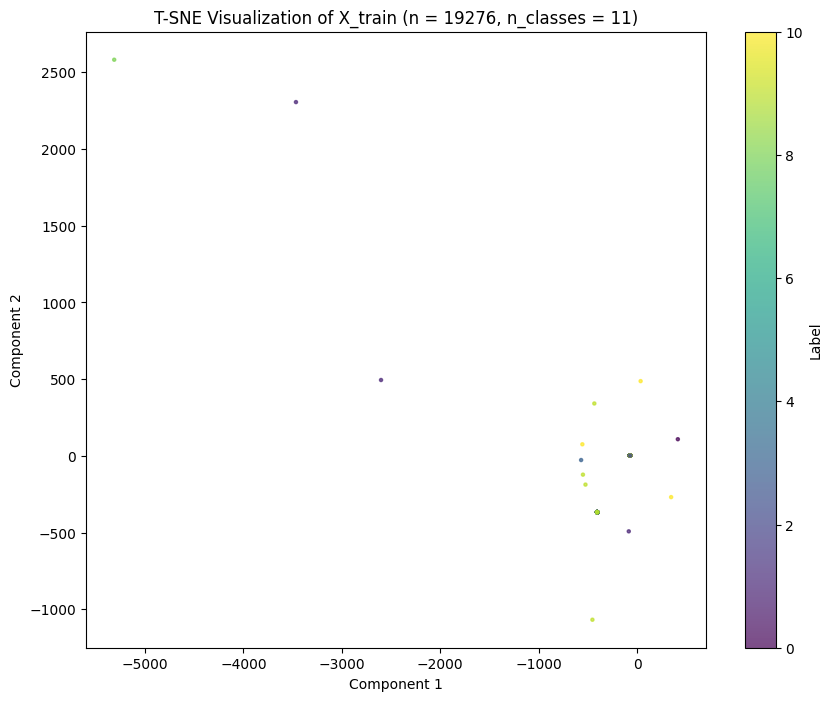

In [265]:
zoom = [-407, -404, -367, -365]
plot_tsne(X_embedded, y_train, zoom=None)

### De-Noising EDA

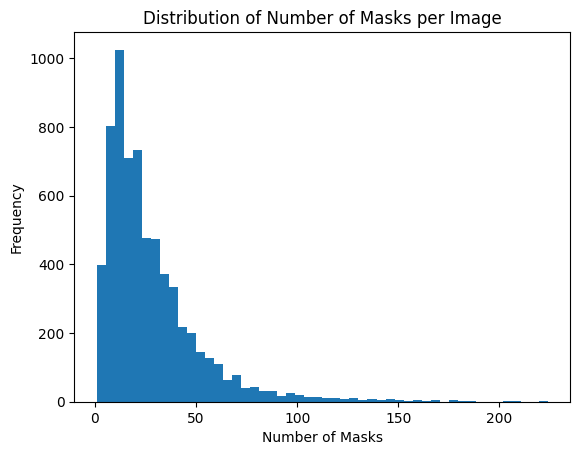

In [3]:
# Look into distribution of number of masks per image
mask_quantities = [len(list(group)) for key, group in groupby(sam_dataset_orig_images)]
plt.hist(mask_quantities, bins=50)
plt.xlabel('Number of Masks')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Masks per Image')
plt.show()

In [4]:
# Also, look into the distribution of the area covered by those masks

def combine_masks(masks):
    """
    Combine a list of masks into a single mask.
    
    Args:
        masks (list of np.ndarray): List of binary masks to combine.

    Returns:
        np.ndarray: Combined mask.
    """
    combined_mask = np.sum(masks, axis=0)
    combined_mask = (combined_mask > 0).astype(np.uint8)  # Ensure the mask is binary
    return combined_mask


def get_image_masks(image_id):
    
    # Go to Data/Image_Masks/{image_id}.json
    with open(os.path.join(MASK_PATH, f"{image_id}.json"), "r") as f:
        sam_image_json = json.load(f)  # Load the JSON file for the image

    # Unpack first n masks from the masks

    mask_data = sorted(sam_image_json['masks'], key=lambda x: -x['area'])

    mask_data = [mask['segmentation'] for mask in mask_data]

    return mask_data


def get_coverage_per_image(orig_images):

    coverages = []
    unique_image_ids = np.unique(orig_images)
    n = len(unique_image_ids)
    for i, image_id in enumerate(unique_image_ids):
        if i % 10 == 0:
            print(f"Processed {i}/{n} images")
        masks = get_image_masks(image_id)
        combined_mask = combine_masks(masks)
        area = np.sum(combined_mask)
        coverage = area / (combined_mask.shape[0] * combined_mask.shape[1])
        coverages.append(coverage)

        

    return unique_image_ids, coverages




In [5]:
#sam_dataset_orig_images

image_ids, coverages = get_coverage_per_image(sam_dataset_orig_images)

Processed 0/6603 images
Processed 10/6603 images
Processed 20/6603 images
Processed 30/6603 images
Processed 40/6603 images
Processed 50/6603 images
Processed 60/6603 images
Processed 70/6603 images
Processed 80/6603 images
Processed 90/6603 images
Processed 100/6603 images
Processed 110/6603 images
Processed 120/6603 images
Processed 130/6603 images
Processed 140/6603 images
Processed 150/6603 images
Processed 160/6603 images
Processed 170/6603 images
Processed 180/6603 images
Processed 190/6603 images
Processed 200/6603 images
Processed 210/6603 images
Processed 220/6603 images
Processed 230/6603 images
Processed 240/6603 images
Processed 250/6603 images
Processed 260/6603 images
Processed 270/6603 images
Processed 280/6603 images
Processed 290/6603 images
Processed 300/6603 images
Processed 310/6603 images
Processed 320/6603 images
Processed 330/6603 images
Processed 340/6603 images
Processed 350/6603 images
Processed 360/6603 images
Processed 370/6603 images
Processed 380/6603 imag

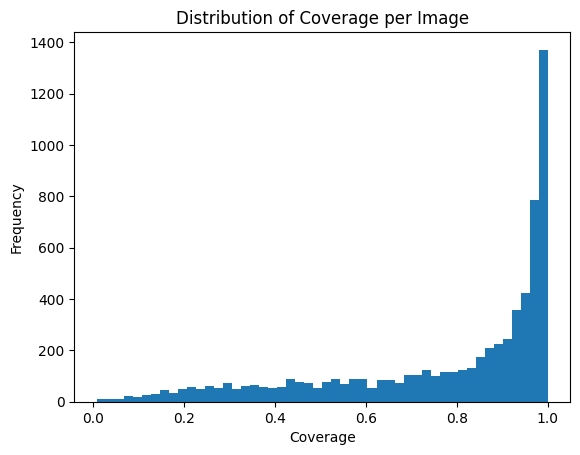

In [7]:
plt.hist(coverages, bins=50)
plt.xlabel('Coverage')
plt.ylabel('Frequency')
plt.title('Distribution of Coverage per Image')
plt.show()

In [290]:
# Then, look at several images from each class and document how the mask with the largest area informs the class itself
